## Check GPU's availability

In [1]:
## The usual imports
import torch
## print out the pytorch version used
print(f"torch version: {torch.__version__}, GPU support: {torch.cuda.is_available()}")

torch version: 2.5.1+cu124, GPU support: True


## Load Trained Model to Test

In [2]:
import pytorch_lightning as pl
from torchmetrics.classification import ConfusionMatrix
from resnet_classifier import *

exp_root = "../../_exp/"
task_name = exp_root + "ClassAB/"
num_classes = 2

if (True): # testing anamal classification
    task_name = exp_root + "Dataset/"
    num_classes = 3

model_name = task_name + "/models/lightning_logs/version_2/checkpoints/epoch=9-step=650.ckpt"
model = ResNetClassifier.load_from_checkpoint(model_name, num_classes=num_classes, resnet_version=50, train_path=task_name+"/train", val_path=task_name+"/val", test_path=task_name+"/test")
model.eval();

In [3]:
trainer = pl.Trainer(default_root_dir=task_name) # (fast_dev_run=3)
# trainer.predict(model, model.test_dataloader());  # result (preds & gts) are stored in model.output_preds & output_gts
trainer.test(model);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/vscode/.local/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │     0.994413435459137     │
│      test_loss_epoch      │    0.05708349123597145    │
└───────────────────────────┴───────────────────────────┘

## Detailed Study of Model's Classification Error

In [4]:
# study confusion matrix on testset: 0-cats (66), 1-dogs (250), 2-horses (42)
y_gts   = torch.cat(model.output_gts).detach().cpu()
y_preds = torch.cat(model.output_preds).detach().cpu()

y_hat  = torch.argmax(y_preds, dim=1)
confmat = ConfusionMatrix(task = 'multiclass', num_classes=model.num_classes)
print(confmat(y_hat, y_gts))

tensor([[ 66,   0,   0],
        [  1, 249,   0],
        [  1,   0,  41]])


Cases falsely classified as class 0


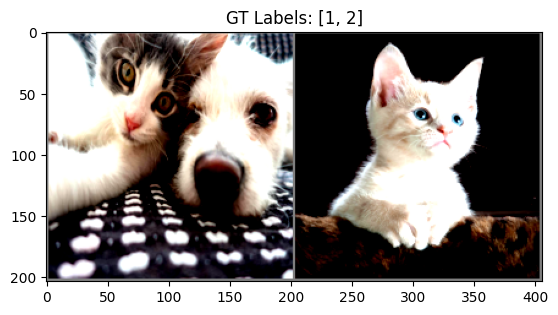

No cases falsely classified as class 1
No cases falsely classified as class 2


In [5]:
from utils import *

testset = model.test_dataloader().dataset
for cls_id in range(model.num_classes):
    show_error_cases(y_hat, y_gts, testset, cls_id)